In [1]:
import transformers as T
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
from ignite.metrics import Rouge
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import jieba
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
lr = 2e-5
epochs = 100
train_batch_size = 1
validation_batch_size = 1
test_batch_size = 1
random_seed = 42
max_length = 300

# path setting that souldn't be changed
tokenizer_path = "./saved_tokenizer"
dataset_path = "./train.xlsx"
test_dataset_path = './test.xlsx'
model_path = "./saved_models"

In [3]:
model = T.AutoModelForSeq2SeqLM.from_pretrained("IDEA-CCNL/Randeng-BART-139M-SUMMARY", cache_dir="./cache/").to(device)
tokenizer = T.AutoTokenizer.from_pretrained("IDEA-CCNL/Randeng-BART-139M-SUMMARY", cache_dir="./cache/", model_max_length=512)
tokenizer.save_pretrained(tokenizer_path)

c:\Users\randy\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\randy\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


('./saved_tokenizer\\tokenizer_config.json',
 './saved_tokenizer\\special_tokens_map.json',
 './saved_tokenizer\\tokenizer.json')

In [4]:
optimizer = AdamW(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

### Data preprocessing

We done text recognition in the main text of the judgment document to mark it with labels, in order to enhance the performance of the fine tuned LLM.

In [5]:
def get_tensor(sample):
    # 將模型的輸入和ground truth打包成Tensor
    model_inputs = tokenizer.batch_encode_plus([each["origin_context"] for each in sample], padding=True, truncation=True, return_tensors="pt")
    model_outputs = tokenizer.batch_encode_plus([each["summary"] for each in sample], padding=True, truncation=True, return_tensors="pt")
    return model_inputs["input_ids"].to(device), model_outputs["input_ids"].to(device)

# The pattern recognition for the main judgment text
facts_pattern = re.compile(r'(.+?)，本院判決如下：', re.DOTALL)
arguments_pattern = re.compile(r'理由(.+?)據上論結', re.DOTALL)
decisions_pattern_1 = re.compile(r'據上論結，(.+?)判決', re.DOTALL)
decisions_pattern_2 = re.compile(r'如下：主文(.+?)。', re.DOTALL)

class Legal_Judgment_Dataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        data_df = pd.read_excel(dataset_path)
        self.data = []
        for index, row in data_df.iterrows():
            main_text = str(row['裁判原文'])
            
            facts = facts_pattern.search(main_text)
            if (facts):
                facts =  '<facts> ' + str(facts.group(1)) + ' </facts>'
            else:
                facts = '<facts>  </facts>'
                
            arguments = arguments_pattern.search(main_text)
            if (arguments):
                arguments = '<arguments> ' + str(arguments.group(1)) + ' </arguments>'
            else:
                arguments = '<arguments>  </arguments>'
                
            decisions = '<decisions> '
            decisions_1 = decisions_pattern_1.search(main_text)
            if (decisions_1):
                decisions_1 = str(decisions_1.group(1))
                decisions += decisions_1
            decisions_2 = decisions_pattern_2.search(main_text)
            if (decisions_2):
                decisions_2 = str(decisions_2.group(1))
                decisions += decisions_2
            decisions += ' </decisions>'
            
            origin_context = "summary: " + f"{facts} {arguments} {decisions}"
            summary = row['摘要']
            self.data.append({"origin_context": origin_context, "summary": summary})

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)


In [ ]:
dataset = Legal_Judgment_Dataset()
train_dataset, untrain_dataset = train_test_split(dataset, test_size=0.2, random_state=random_seed)
test_dataset, validation_dataset = train_test_split(untrain_dataset, test_size=0.5, random_state=random_seed)
summary_train = DataLoader(train_dataset, collate_fn=get_tensor, batch_size=train_batch_size, shuffle=True)
summary_validation = DataLoader(validation_dataset, collate_fn=get_tensor, batch_size=validation_batch_size, shuffle=False)

rouge = Rouge(variants=["L", 2], multiref="best")
print(f"Dataset example: \n{train_dataset[0]} \n{train_dataset[1]} \n{train_dataset[2]}")

In [7]:
def evaluate(model, dataset, ep):
    pbar = tqdm(dataset)
    pbar.set_description(f"Evaluating")
    loss_list = []
    for inputs, targets in pbar:
        loss = model(inputs, labels=targets).loss
        loss_list.append(loss.item())
        pbar.set_postfix(loss = loss.item())
        outputs = [each.replace("<unk>", "").replace("<pad>","") for each in tokenizer.batch_decode(model.generate(inputs, max_length=max_length))]
        targets = [each.replace("<unk>", "").replace("<pad>","") for each in tokenizer.batch_decode(targets)]
        if ep % 10 == 0:
            print("model generate examples:")
            print(f"output: {outputs}")
            print(f"target: {targets}")
        for out, tar in zip(outputs, targets):
            sentence = " ".join(jieba.cut(out)).split()
            ground_truth = " ".join(jieba.cut(tar)).split()
            for s in sentence:
                rouge.update(([s], [ground_truth]))
            
    return rouge.compute(), np.mean(np.array(loss_list))

In [ ]:
training_history = np.array([])
validation_history = np.array([])
rouge_L_P_history = np.array([])
rouge_L_R_history = np.array([])
rouge_L_F_history = np.array([])
rouge_2_P_history = np.array([])
rouge_2_R_history = np.array([])
rouge_2_F_history = np.array([])
best_val_score = {'Rouge-L-P': 0.0, 
                  'Rouge-L-R': 0.0, 
                  'Rouge-L-F': 0.0, 
                  'Rouge-2-P': 0.0, 
                  'Rouge-2-R': 0.0, 
                  'Rouge-2-F': 0.0
                  }

def dict_compare(val):
    if val['Rouge-L-P'] > best_val_score['Rouge-L-P'] or \
       val['Rouge-L-R'] > best_val_score['Rouge-L-R'] or \
       val['Rouge-L-F'] > best_val_score['Rouge-L-F'] or \
       val['Rouge-2-P'] > best_val_score['Rouge-2-P'] or \
       val['Rouge-2-R'] > best_val_score['Rouge-2-R'] or \
       val['Rouge-2-F'] > best_val_score['Rouge-2-F']:
        return True
    return False

for ep in range(epochs):
    model.train()
    pbar = tqdm(summary_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    loss_list = []
    for inputs, targets in pbar:
        optimizer.zero_grad()
        loss = model(input_ids=inputs, labels=targets).loss
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss = loss.item())
    training_history = np.append(training_history, np.mean(np.array(loss_list)))
    
    model.eval()
    
    validation_score, validation_loss = evaluate(model, summary_validation, ep)
    validation_history = np.append(validation_history, validation_loss)
    rouge_L_P_history = np.append(rouge_L_P_history, validation_score['Rouge-L-P'])
    rouge_L_R_history = np.append(rouge_L_R_history, validation_score['Rouge-L-R'])
    rouge_L_F_history = np.append(rouge_L_F_history, validation_score['Rouge-L-F'])
    rouge_2_P_history = np.append(rouge_2_P_history, validation_score['Rouge-2-P'])
    rouge_2_R_history = np.append(rouge_2_R_history, validation_score['Rouge-2-R'])
    rouge_2_F_history = np.append(rouge_2_F_history, validation_score['Rouge-2-F'])
    
    scheduler.step(validation_loss)
    if dict_compare(validation_score):
        best_val_score = validation_score
        torch.save(model, 'judgment_summarization.mod')
    
    print(f"Rouge-2 score on epoch {ep}:", validation_score)
torch.save(model, f'{model_path}/ep{ep}.mod')

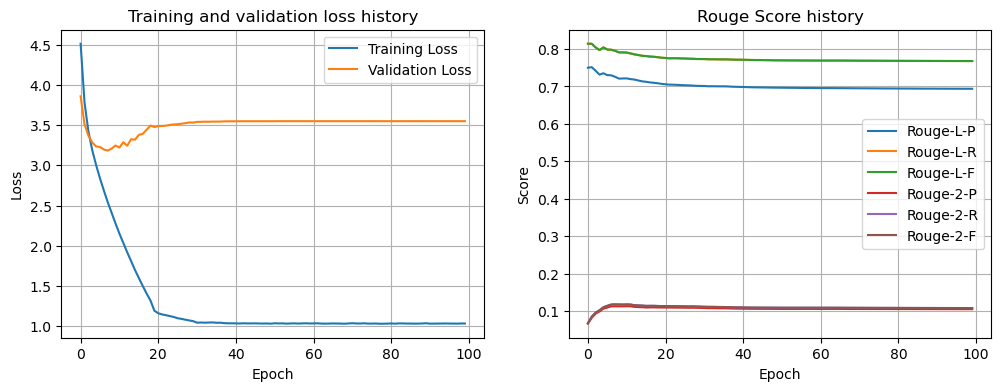

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Training and validation loss history")
plt.plot(training_history, label="Training Loss")
plt.plot(validation_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.title("Rouge Score history")
plt.plot(rouge_L_P_history, label="Rouge-L-P")
plt.plot(rouge_L_R_history, label="Rouge-L-R")
plt.plot(rouge_L_F_history, label="Rouge-L-F")
plt.plot(rouge_2_P_history, label="Rouge-2-P")
plt.plot(rouge_2_R_history, label="Rouge-2-R")
plt.plot(rouge_2_F_history, label="Rouge-2-F")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid()

plt.savefig("training_history.png")

### Testing the model

In [10]:
def test(model, test_dataset):
    model.eval()
    pbar = tqdm(test_dataset)
    pbar.set_description(f"Testing")

    for idx, testdata in tqdm(test_dataset.iterrows(), total=test_dataset.shape[0]):
        main_text = str(testdata['裁判原文'])
            
        facts = facts_pattern.search(main_text)
        if (facts):
            facts =  '<facts> ' + str(facts.group(1)) + ' </facts>'
        else:
            facts = '<facts>  </facts>'
            
        arguments = arguments_pattern.search(main_text)
        if (arguments):
            arguments = '<arguments> ' + str(arguments.group(1)) + ' </arguments>'
        else:
            arguments = '<arguments>  </arguments>'
            
        decisions = '<decisions> '
        decisions_1 = decisions_pattern_1.search(main_text)
        if (decisions_1):
            decisions_1 = str(decisions_1.group(1))
            decisions += decisions_1
        decisions_2 = decisions_pattern_2.search(main_text)
        if (decisions_2):
            decisions_2 = str(decisions_2.group(1))
            decisions += decisions_2
        decisions += ' </decisions>'
        
        ori_data = "summary: " + f"{facts} {arguments} {decisions}"
        inputs = tokenizer(ori_data, padding=True, truncation=True, return_tensors="pt").to(device)
        outputs_context = tokenizer.decode(model.generate(**inputs, max_length=max_length)[0])
        outputs = outputs_context.replace("<unk>", "").replace("<pad>","")
        test_dataset.loc[idx, "摘要"] = outputs
    
    return test_dataset

In [11]:
test_dataset = pd.read_excel(test_dataset_path)
test_dataset['摘要'] = None
result_data = test(model, test_dataset)
result_data.to_excel("result.xlsx", index=False)

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]